## Import libraries<a name="import"></a>

In [1]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np

from my_functions import *


### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [2]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio\SRC
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [3]:
plt.close("all")  # close all figure windows

## Initialization

### Xdf file selection and loading (REARM data)

In [4]:
# Define the xdf file of interest
xdf_input_filename="001_MolLud_20201112_1_c.xdf"
#xdf_input_filename="020_DesMar_20211129_1_c.xdf"

xdf_input_filepath=os.path.normpath("DAT/INPUT/"+xdf_input_filename)

In [5]:
# definition of the EEG channels' names
channels_dict = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

### Retrieve EEG data

In [6]:
EEG_data=retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="EEG")
EEG_srate=EEG_data["infos"]["sample_rate"]["effective"]
print(EEG_srate)
EEG_amplitudes_centered=detrend_signals(EEG_data["data"]["time_series"])
EEG_amplitudes_rereferenced=rereference_signals(input_signals=EEG_amplitudes_centered)
EEG_amplitudes_centered_filtered,_,_=filter_signal(input_signals=EEG_amplitudes_rereferenced,
                                            sample_rate=EEG_srate,
                                            order=8,cutofffreq=(5,100,50))
EEG_timestamps=EEG_data["data"]["timestamps"]-EEG_data["data"]["timestamps"][0]

Accessing stream: 
Type: 'EEG' | Name: 'LSLOutletStreamName-EEG'
499.9977270435165
input_signals shape:
 (221938, 8)
input_signals mean per signal:
 [27897.195 26144.139 28026.402 35319.527 31324.672 24827.713 32372.799
 29788.95 ]
input_signals shape:(221938, 8)
input_signals whole mean:13.818697929382324
mean_vector shape: ()
LOW_CUTOFF_FREQ_THEORETICAL=5,HIGH_CU-TOFF_FREQ_THEORETICAL=100
LOW_CUTOFF_FREQ_CORRECTED=4.732,HIGH_CUTOFF_FREQ_CORRECTED=104.203
NOTCH_CUTOFF_FREQ=50
Filtered signal shape: (221938, 8)


### Retrieve mouse marker data

In [7]:
mouse_marker_times_labels = create_marker_times_labels_array2(xdf_input_filepath=xdf_input_filepath)
mouse_marker_times_labels[:,0] -= EEG_data["data"]["timestamps"][0] #make times start in reference to the first EEG timestamp instead of unix epoch.


Accessing stream: 
Type: 'Markers' | Name: 'MouseToNIC'


### Retrieve mouse mocap data

In [8]:
mouse_mocap_data=retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="MoCap",stream_name="Mouse")

mouse_mocap_sample_rate = mouse_mocap_data["infos"]["sample_rate"]["effective"]
mouse_mocap_times = mouse_mocap_data["data"]["timestamps"]-EEG_data["data"]["timestamps"][0] #make times start in reference to the first EEG timestamp instead of unix epoch.

mouse_mocap_positions_xy = mouse_mocap_data["data"]["time_series"][:,0:2] #select only x and y position data
mouse_mocap_positions_units = np.unique(mouse_mocap_data["infos"]["channels"]["units"][0:2])[0]


Accessing stream: 
Type: 'MoCap' | Name: 'Mouse'


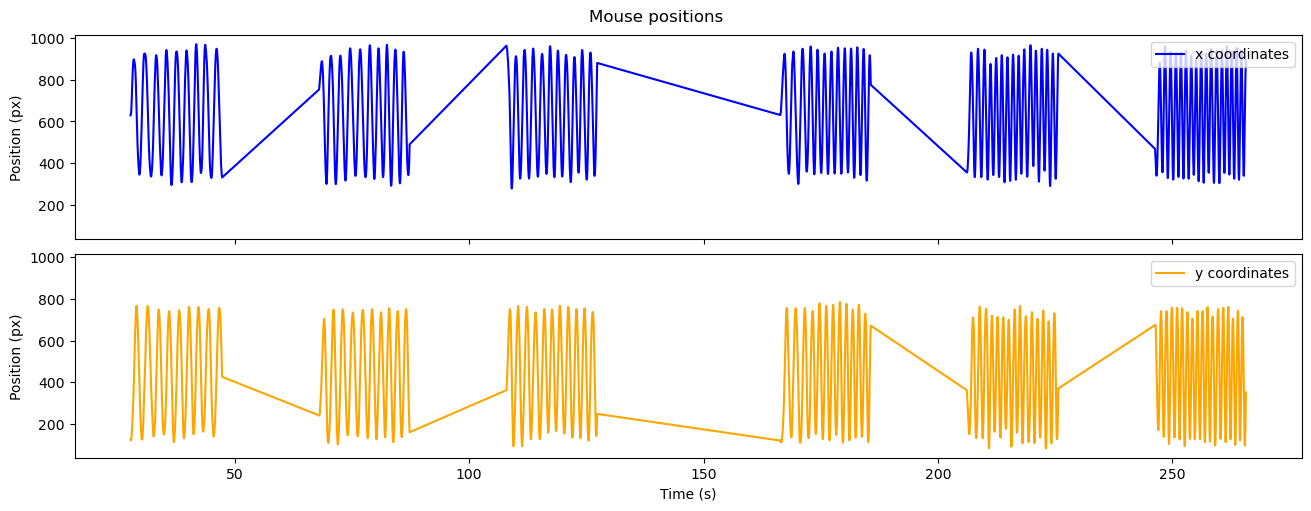

In [9]:
figure,axis=plt.subplots(2, sharex=True, sharey=True, layout="constrained", figsize=(13,5))
figure.suptitle("Mouse positions")

axis[0].plot(mouse_mocap_times,mouse_mocap_positions_xy[:,0], label="x coordinates",color="b")
axis[0].set_ylabel("Position (px)")
axis[0].legend(loc="upper right")

axis[1].plot(mouse_mocap_times,mouse_mocap_positions_xy[:,1], label="y coordinates",color="orange")
axis[1].set_ylabel("Position (px)")
axis[1].set_xlabel("Time (s)")
axis[1].legend(loc="upper right")

### Compute tangential speeds

In [10]:
mouse_mocap_speeds = compute_tangential_speed(coordinates=mouse_mocap_positions_xy,
                                            sample_rate=mouse_mocap_sample_rate)

mouse_mocap_speeds_threshold = 0.05*np.max(mouse_mocap_speeds) #define a threshold

print(f"mouse_mocap_speed_threshold = {mouse_mocap_speeds_threshold} ({mouse_mocap_positions_units}/s) ")
print(f"vt_max= {np.max(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")
print(f"vt_min= {np.min(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")
print(f"vt_moy= {np.mean(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")

mouse_mocap_speed_threshold = 3013.5616374589035 (pixels/s) 
vt_max= 60271.23274917807 (pixels/s)
vt_min= 93.92532860411228 (pixels/s)
vt_moy= 1270.3016690899083 (pixels/s)


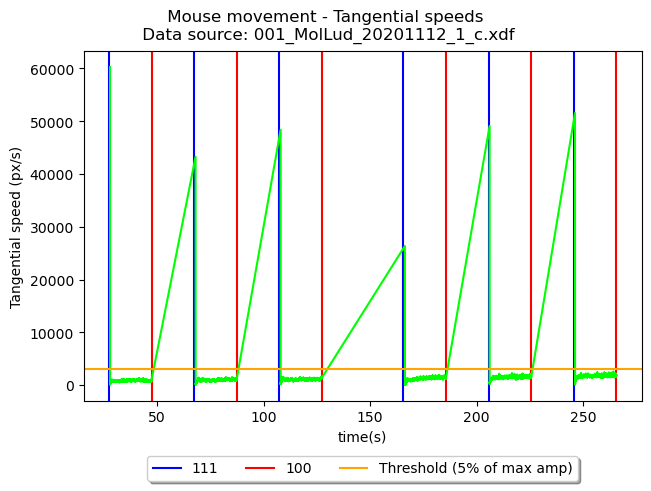

In [11]:
figure,axis=plt.subplots(layout="constrained")
figure.suptitle(f" Mouse movement - Tangential speeds \n Data source: {xdf_input_filename}")
show_markers2(plot_type=axis, markers_times_array=mouse_marker_times_labels)

axis.plot(mouse_mocap_times,mouse_mocap_speeds,color="lime",linewidth=1.5)


axis.axhline(mouse_mocap_speeds_threshold,label="Threshold (5% of max amp)",color="orange")
axis.set_ylabel("Tangential speed (px/s)")
axis.set_xlabel("time(s)")
axis.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3)

In [12]:
#Select EEG channel
print(channels_dict)
selected_channel_num=[1,5]


{'Channel_1': 'C4', 'Channel_2': 'FC2', 'Channel_3': 'FC6', 'Channel_4': 'CP2', 'Channel_5': 'C3', 'Channel_6': 'FC1', 'Channel_7': 'FC5', 'Channel_8': 'CP1'}


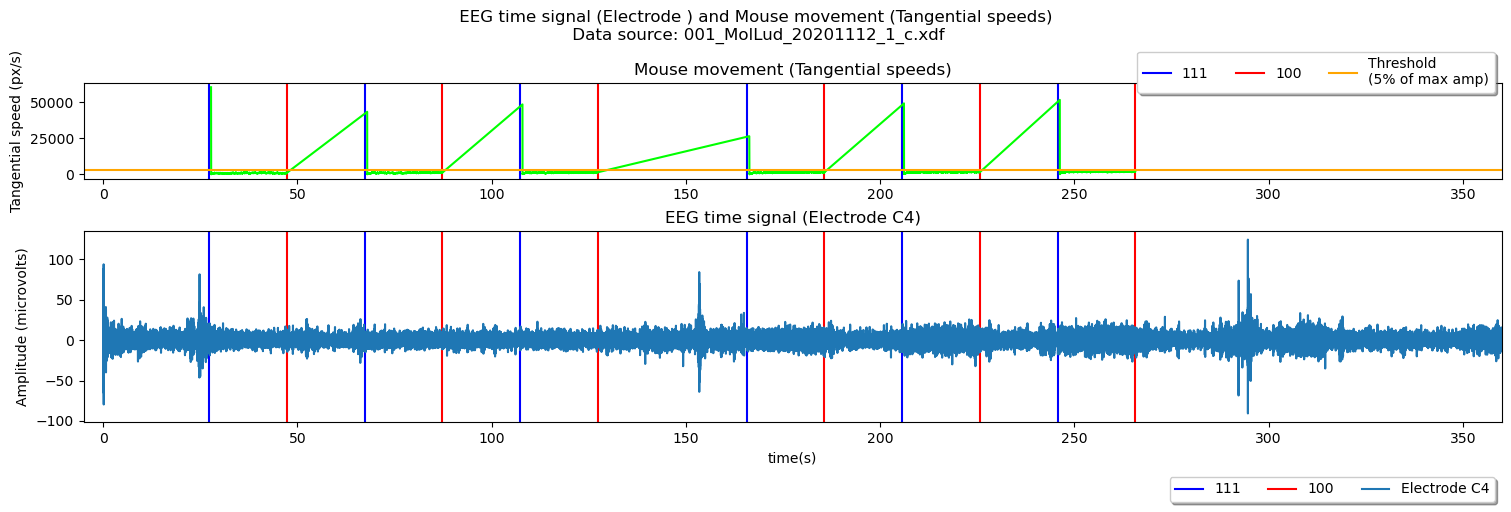

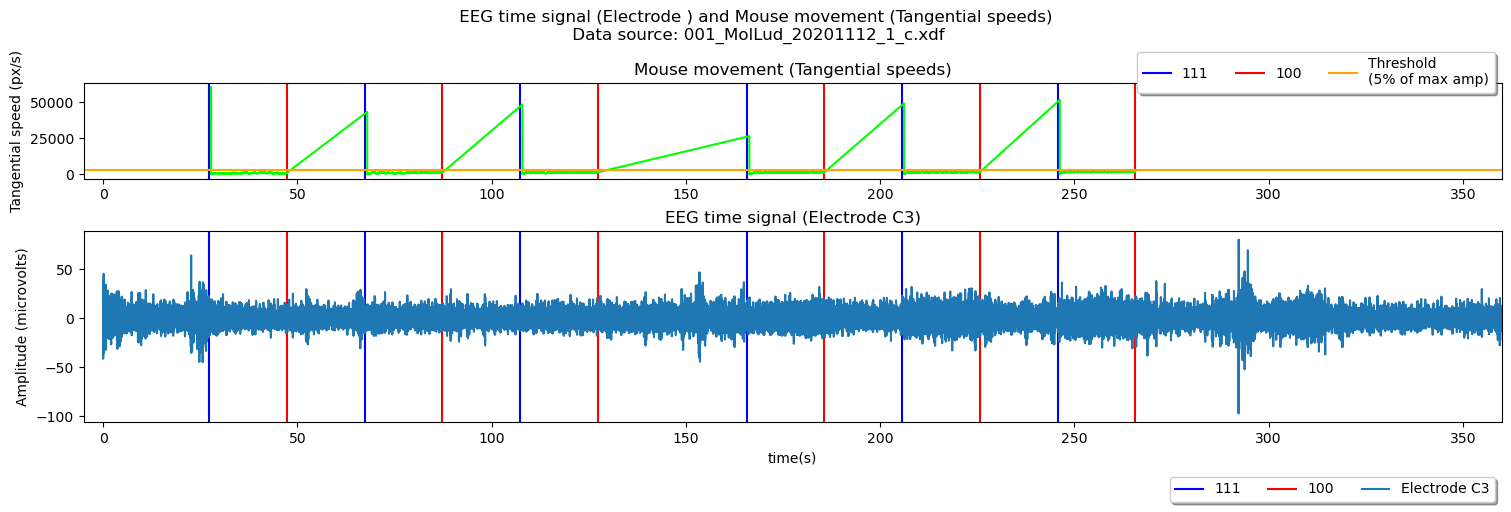

In [13]:
for channel in selected_channel_num:
    channel_num=channel
    channel_index=channel_num-1 #cf python indexing

    figure,axis=plt.subplots(2,layout="constrained",figsize=(15,5),gridspec_kw={'height_ratios': [1, 2]})
    figure.suptitle(f" EEG time signal (Electrode ) and Mouse movement (Tangential speeds) \n Data source: {xdf_input_filename}")

    show_markers2(plot_type=axis[0], markers_times_array=mouse_marker_times_labels)
    axis[0].plot(mouse_mocap_times,mouse_mocap_speeds,color="lime",linewidth=1.5)
    axis[0].set_title("Mouse movement (Tangential speeds)")
    axis[0].set_xlim(left=-5,right=360)
    axis[0].axhline(mouse_mocap_speeds_threshold,label="Threshold \n(5% of max amp)",color="orange")
    axis[0].set_ylabel("Tangential speed (px/s)")
    axis[0].legend(loc='upper right',bbox_to_anchor=(1, 1.40), fancybox=True, shadow=True, ncol=3)

    show_markers2(plot_type=axis[1], markers_times_array=mouse_marker_times_labels)
    axis[1].plot(EEG_timestamps,EEG_amplitudes_centered_filtered[:,channel_index],label=f"Electrode {channels_dict[f'Channel_{channel_num}']}")
    axis[1].set_title(f"EEG time signal (Electrode {channels_dict[f'Channel_{channel_num}']})")
    axis[1].set_xlim(left=-5,right=360)
    axis[1].set_ylabel(f"Amplitude ({EEG_data['infos']['channels']['units'][0]})")
    axis[1].set_xlabel("time(s)")
    axis[1].legend(loc='upper right',bbox_to_anchor=(1, -0.25), fancybox=True, shadow=True, ncol=3)
